# Chernoff Faces

This notebook is the start of three in total to understand if transforming numerical data to images would improve classification tasks through deep learning techniques such as convolutional neural networks (CNNs). This notebook creates 4 data sets sampled from multi-level gaussian models, and each data point is then mapped to a visual representation in the form of a [Chernoff face](https://en.wikipedia.org/wiki/Chernoff_face). The output of this notebook are both images and numerical data. The images are fed to a CNN for classification task in the notebook [chernoff-deeplearning.ipynb](chernoff-deeplearning.ipynb), and the numerical data are fed into numerical classification models such as logistic regression and random forest in the notebook [chernoff-classification.ipynb](chernoff-classification.ipynb).

## Models

We have 4 data sets that we sample, each composed of 18 variables. Each observation is then mapped to a Chernoff face. The models used to generate each sample is as follows.

* $X_0 = 0.9$
* $X_1 \sim \mathcal{N}(R, 0.1)$, where $R \in [0, 1]$ but constant per model
* $X_2 \sim \mathcal{N}(0.3 x_1, 0.1)$
* $X_3 \sim \mathcal{N}(0.25 x_1, 0.1)$
* $X_4 \sim \mathcal{N}(0.25 x_2 + 0.33 x_3, 0)$
* $X_5 \sim \mathcal{N}(0.77 x_4, 0.1)$
* $X_6 \sim \mathcal{N}(0.66 x_4, 0.2)$
* $X_7 \sim \mathcal{N}(0.33 x_4, 0.02)$
* $X_8 \sim \mathcal{N}(0.2 x_5 + 0.32 x_6 + 0.18 x_7, 0.1)$
* $X_9 \sim \mathcal{N}(0.5 x_8, 0.03)$
* $X_{10} \sim \mathcal{N}(0.2 x_9, 0.05)$
* $X_{11} \sim \mathcal{N}(0.3 x_9 + 0.4 x_{10}, 0.03)$
* $X_{12} \sim \mathcal{N}(0.4 x_{10} + 0.25 x_{11}, 0.08)$
* $X_{13} \sim \mathcal{N}(0.2 x_{10} + 0.2 x_{11} + 0.12 x_{12}, 0)$
* $X_{14} \sim \mathcal{N}(0.5 x_{13}, 0.01)$
* $X_{15} \sim \mathcal{N}(0.5 x_{14}, 0.01)$
* $X_{16} \sim \mathcal{N}(0.5 x_{15}, 0.01)$
* $X_{17} \sim \mathcal{N}(0.5 x_{16}, 0.01)$

Note that the coefficients and standard deviations are very small, since the values (per observation) are required to be in $[0, 1]$. In some cases, negative values may occur, and a normalization of the values back to the domain of $[0, 1]$ is made. The graphical representation looks like the following.

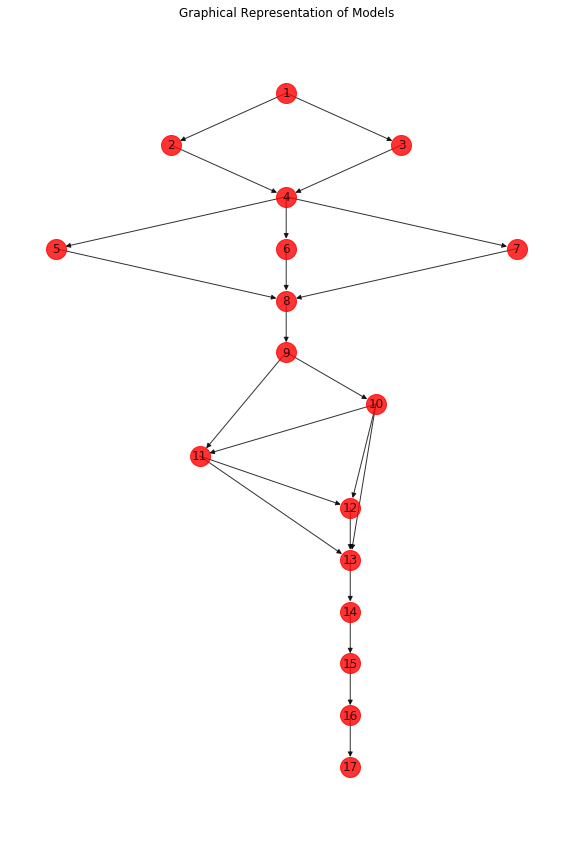

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

np.random.seed(37)

G = nx.DiGraph()
G.add_edges_from([
    (1, 2),
    (1, 3),
    (2, 4), (3, 4),
    (4, 5),
    (4, 6),
    (4, 7),
    (5, 8), (6, 8), (7, 8),
    (8, 9),
    (9, 10),
    (9, 11), (10, 11),
    (10, 12), (11, 12),
    (10, 13), (11, 13), (12, 13),
    (13, 14),
    (14, 15),
    (15, 16),
    (16, 17)
])

with warnings.catch_warnings(record=True):
    fig, ax = plt.subplots(figsize=(10, 15))
    options = {
        'node_color': 'red',
        'node_size': 400,
        'width': 1,
        'alpha': 0.8
    }
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    nx.draw(G, with_labels=True, ax=ax, pos=pos, **options)
    ax.set_title('Graphical Representation of Models')
    plt.axis('off')
    plt.show()

## Sampling

The sampling is performed below.

In [2]:
from matplotlib.patches import Ellipse, Arc
import pandas as pd
import os

class Face():
    def __init__(self, coef=None):
        if coef is None:
            self.coef_ = np.insert(np.random.rand(17), 0, 0.9)
        else:
            self.coef_ = coef
    
    def next(self, N=1):
        x0 = np.full((1, N), self.coef_[0])
        x1 = np.random.normal(self.coef_[1], 0.1, N)
        x2 = np.random.normal(0.3 * x1, 0.1, N)
        x3 = np.random.normal(0.25 * x1, 0.1, N)
        x4 = np.random.normal(0.25 * x2 + 0.33 * x3, 0.2, N)
        x5 = np.random.normal(0.77 * x4, 0.1, N)
        x6 = np.random.normal(0.66 * x4, 0.2, N)
        x7 = np.random.normal(0.33 * x4, 0.02, N)
        x8 = np.random.normal(0.20 * x5 + 0.32 * x6 + 0.18 * x7, 0.1, N)
        x9 = np.random.normal(0.5 * x8, 0.03, N)
        x10 = np.random.normal(0.2 * x9, 0.05, N)
        x11 = np.random.normal(0.3 * x9 + 0.4 * x10, 0.03, N)
        x12 = np.random.normal(0.4 * x10 + 0.25 * x11, 0.08, N)
        x13 = np.random.normal(0.2 * x10 + 0.02 * x11 + 0.12 * x12, 0.05, N)
        x14 = np.random.normal(0.5 * x13, 0.01, N)
        x15 = np.random.normal(0.5 * x14, 0.01, N)
        x16 = np.random.normal(0.5 * x15, 0.01, N)
        x17 = np.random.normal(0.5 * x16, 0.01, N)
        
        a = np.vstack([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17]).T
        b = (a - np.min(a))/np.ptp(a)
        return b
    

def cface(x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,width=3,height=3,odir=None,ofile=None,ax=None):
    # x1 = height  of upper face
    # x2 = overlap of lower face
    # x3 = half of vertical size of face
    # x4 = width of upper face
    # x5 = width of lower face
    # x6 = length of nose
    # x7 = vertical position of mouth
    # x8 = curvature of mouth
    # x9 = width of mouth
    # x10 = vertical position of eyes
    # x11 = separation of eyes
    # x12 = slant of eyes
    # x13 = eccentricity of eyes
    # x14 = size of eyes
    # x15 = position of pupils
    # x16 = vertical position of eyebrows
    # x17 = slant of eyebrows
    # x18 = size of eyebrows
    
    # transform some values so that input between 0,1 yields variety of output
    x3 = 1.9*(x3-.5)
    x4 = (x4+.25)
    x5 = (x5+.2)
    x6 = .3*(x6+.01)
    x8 = 5*(x8+.001)
    x11 /= 5
    x12 = 2*(x12-.5)
    x13 += .05
    x14 += .1
    x15 = .5*(x15-.5)
    x16 = .25*x16
    x17 = .5*(x17-.5)
    x18 = .5*(x18+.1)

    if ax is None:
        fig = plt.figure(frameon=False)
        fig.set_size_inches(width, height)

        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        
    # top of face, in box with l=-x4, r=x4, t=x1, b=x3
    e = Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='blue', linewidth=10)
    ax.add_artist(e)

    # bottom of face, in box with l=-x5, r=x5, b=-x1, t=x2+x3
    e = Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='blue', linewidth=10)
    ax.add_artist(e)

    # cover overlaps
    e = Ellipse( (0,(x1+x3)/2), 2*x4, (x1-x3), fc='white', ec='none')
    ax.add_artist(e)
    e = Ellipse( (0,(-x1+x2+x3)/2), 2*x5, (x1+x2+x3), fc='white', ec='none')
    ax.add_artist(e)
    
    # draw nose
    ax.plot([0,0], [-x6/2, x6/2], 'k')
    
    # draw mouth
    p = Arc( (0,-x7+.5/x8), 1/x8, 1/x8, theta1=270-180/np.pi*np.arctan(x8*x9), theta2=270+180/np.pi*np.arctan(x8*x9))
    ax.add_artist(p)
    
    # draw eyes
    p = Ellipse( (-x11-x14/2,x10), x14, x13*x14, angle=-180/np.pi*x12, facecolor='yellow')
    ax.add_artist(p)
    
    p = Ellipse( (x11+x14/2,x10), x14, x13*x14, angle=180/np.pi*x12, facecolor='green')
    ax.add_artist(p)

    # draw pupils
    p = Ellipse( (-x11-x14/2-x15*x14/2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)
    p = Ellipse( (x11+x14/2-x15*x14/2, x10), .05, .05, facecolor='black')
    ax.add_artist(p)
    
    # draw eyebrows
    ax.plot([-x11-x14/2-x14*x18/2,-x11-x14/2+x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')
    ax.plot([x11+x14/2+x14*x18/2,x11+x14/2-x14*x18/2],[x10+x13*x14*(x16+x17),x10+x13*x14*(x16-x17)],'k')
    
    ax.axis([-1.2,1.2,-1.2,1.2])
    ax.set_xticks([])
    ax.set_yticks([])
    if odir is not None and ofile is not None:
        opath = '{}/{}'.format(odir, ofile)
        fig.savefig(opath, quality=100, optimize=True)

def plot(X):
    fig = plt.figure(figsize=(11,11))
    for i in range(X.shape[0]):
        ax = fig.add_subplot(5,5,i+1,aspect='equal')
        cface(*X[i], ax=ax)

    fig.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    plt.show()
    
def save_plots(X, offset=0, width=3, height=3, odir=None):
    for i in range(X.shape[0]):
        num = f'{i+offset:03}'
        ofile = '{}.jpg'.format(num)
        cface(*X[i], width=width, height=height, odir=odir, ofile=ofile)
        plt.close()
        
def make_dirs(num_clazzes, root_path='./faces'):
    tr_path = '{}/train'.format(root_path)
    te_path = '{}/test'.format(root_path)
    va_path = '{}/valid'.format(root_path)
    
    dir_paths = [tr_path, te_path, va_path]
    
    for dir_path in dir_paths:
        for i in range(num_clazzes):
            num = f'{i:02}'
            subfolder_path = '{}/{}'.format(dir_path, num)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
                print('creating {}'.format(subfolder_path))
            else:
                print('{} already exists'.format(subfolder_path))

In [3]:
f0 = Face()
f1 = Face()
f2 = Face()
f3 = Face()

X0 = f0.next(250)
X1 = f1.next(250)
X2 = f2.next(75)
X3 = f3.next(75)

faces = [X0, X1, X2, X3]
tr_indices = [(0, 200), (0, 200), (0, 25), (0, 25)]
te_indices = [(200, 225), (200, 225), (25, 50), (25, 50)]
va_indices = [(225, 250), (225, 250), (50, 75), (50, 75)]

make_dirs(len(faces))

./faces/train/00 already exists
./faces/train/01 already exists
./faces/train/02 already exists
./faces/train/03 already exists
./faces/test/00 already exists
./faces/test/01 already exists
./faces/test/02 already exists
./faces/test/03 already exists
./faces/valid/00 already exists
./faces/valid/01 already exists
./faces/valid/02 already exists
./faces/valid/03 already exists


## Create the faces

Each data point (observation of 18 variables) is then used to create a Chernoff face and saved.

In [4]:
for clazz, (X, tr, te, va) in enumerate(zip(faces, tr_indices, te_indices, va_indices)):
    X_tr = X[tr[0]:tr[1], :]
    X_te = X[te[0]:te[1], :]
    X_va = X[va[0]:va[1], :]
    
    num = f'{clazz:02}'
    
    dir_tr = './faces/train/{}'.format(num)
    dir_te = './faces/test/{}'.format(num)
    dir_va = './faces/valid/{}'.format(num)
    
    save_plots(X_tr, offset=tr[0], odir=dir_tr)
    save_plots(X_te, offset=te[0], odir=dir_te)
    save_plots(X_va, offset=va[0], odir=dir_va)
print('done!')

done!


### Faces in class 0

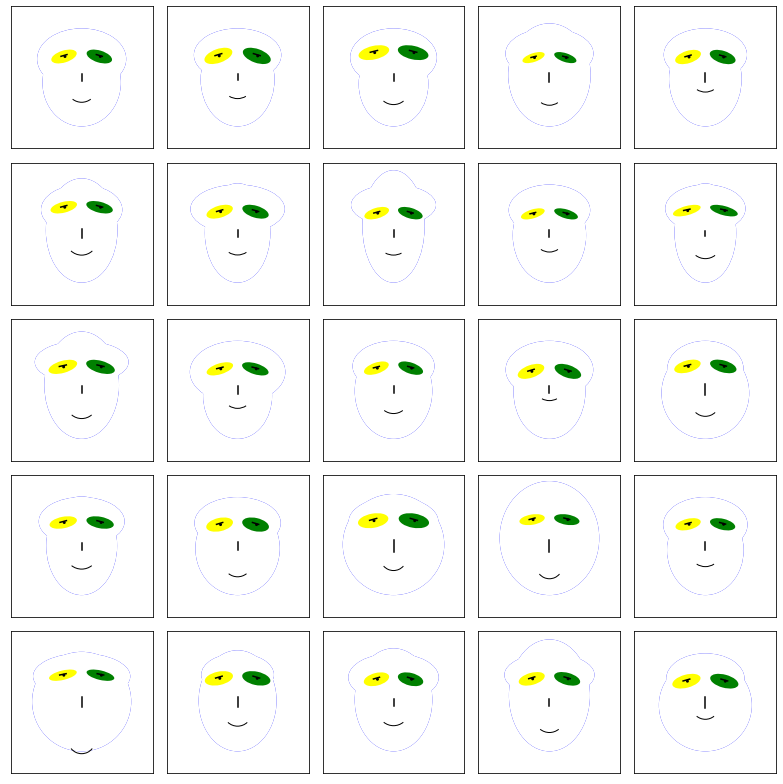

In [5]:
plot(X0[0:25,:])

### Faces in class 1

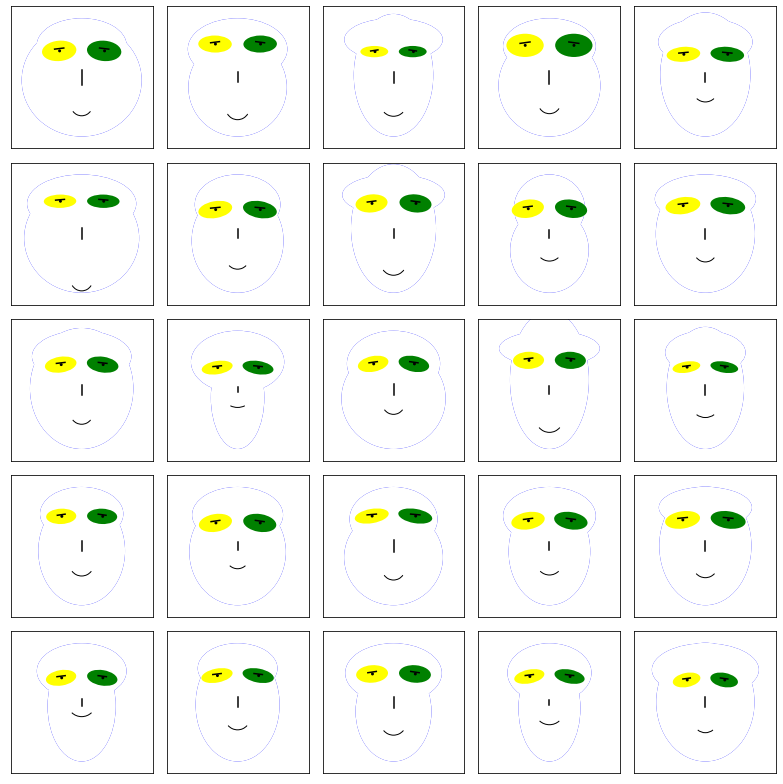

In [6]:
plot(X1[0:25,:])

### Faces in class 2

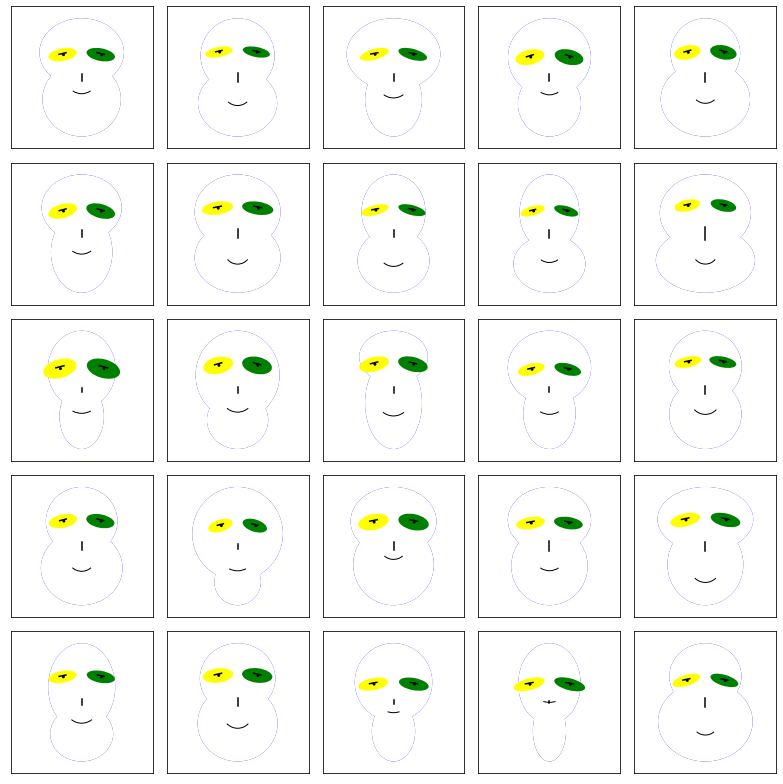

In [7]:
plot(X2[0:25,:])

### Faces in class 3

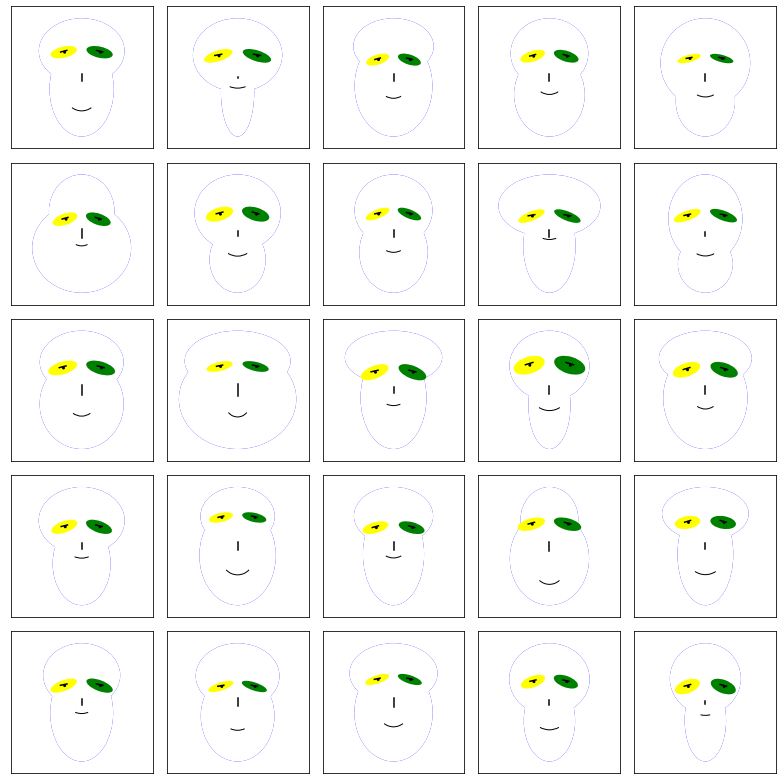

In [8]:
plot(X3[0:25,:])

## Export raw data

The numerical data is also exported.

In [9]:
TR = []
VA = []
for clazz, (X, tr, te, va) in enumerate(zip(faces, tr_indices, te_indices, va_indices)):
    X_tr = X[tr[0]:tr[1], :]
    X_va = X[va[0]:va[1], :]
    
    X = X_tr
    y = np.full((X.shape[0], 1), clazz, dtype=np.int)
    data = np.hstack([X, y])
    TR.append(data)
    
    X = X_va
    y = np.full((X.shape[0], 1), clazz, dtype=np.int)
    data = np.hstack([X, y])
    VA.append(data)

TR = np.vstack(TR)
VA = np.vstack(VA)

print(TR.shape)
print(VA.shape)

cols = ['x{}'.format(i) if i < TR.shape[1] - 1 else 'y' for i in range(TR.shape[1])]
tr_df = pd.DataFrame(TR, columns=cols)
va_df = pd.DataFrame(VA, columns=cols)

tr_df = tr_df.astype({'y': 'int32'})
va_df = va_df.astype({'y': 'int32'})

tr_df.to_csv('./faces/data-train.csv', index=False, header=True)
va_df.to_csv('./faces/data-valid.csv', index=False, header=True)

(450, 19)
(100, 19)


In [10]:
tr_df.dtypes

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
y        int32
dtype: object

In [11]:
va_df.dtypes

x0     float64
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
x11    float64
x12    float64
x13    float64
x14    float64
x15    float64
x16    float64
x17    float64
y        int32
dtype: object